command line to run jupyter presentation
jupyter nbconvert GW_Presentation.ipynb --to slides --post serve

## Gravitational Waves

Gravitational waves are ripples in the curvature of spacetime that are generated in certain gravitational interactions and propagate as waves outward from their source at the speed of light. 

As a gravitational wave passes an observer, that observer will find spacetime distorted by the effects of strain. Distances between objects increase and decrease rhythmically as the wave passes, at a frequency corresponding to that of the wave.



On September 14, 2015 at 09:50:45 UTC two detectors of the Laser Interferometer Gravitational-Wave Observatory simultaneously observed a transient gravitational-wave signal. The signal sweeps upwards in frequency from 35 to 250 Hz with a peak gravitational-wave strain of 1.0 × 10-21. It matches the waveform predicted by general relativity for the inspiral and merger of a pair of black holes and the ringdown of the resulting single black hole. 


<img src="images/inspiral_merger_ringdown.png" width="800" height="600">

The signal was observed with a matched-filter signal-to-noise ratio of 24 and a false alarm rate estimated to be less than 1 event per 203 000 years, equivalent to a significance greater than 5.1 σ. The source lies at a luminosity distance of 410+160
−180 Mpc corresponding to a redshift z = 0.09+0.03
−0.04. In the source frame, the initial black hole masses are 36+5
−4 M☉ and 29+4
−4 M☉, and the final black hole mass is 62+4
−4 M☉, with 3.0+0.5
−0.5  M☉c2 radiated in gravitational waves. All uncertainties define 90% credible intervals. These observations demonstrate the existence of binary stellar-mass black hole systems. This is the first direct detection of gravitational waves and the first observation of a binary black hole merger.

In [1]:
## Initialize envornmental variables

# Standard python numerical analysis imports:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl

#----------------------------------------------------------------
# Load LIGO data from a single file
#----------------------------------------------------------------
# First from H1
#fn_H1 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
fn_H1 = 'H-H1_LOSC_4_V1-1126257414-4096.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
# and then from L1
#fn_L1 = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
fn_L1 = 'L-L1_LOSC_4_V1-1126257414-4096.hdf5'
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# sampling rate:
fs = 4096
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# read in the NR template
NRtime, NR_H1 = np.genfromtxt('GW150914_4_NR_waveform.txt').transpose()

## Entire code to transform and whiten GW data

In [2]:
#----------------------------------------------------------------
# Run all calculations
#----------------------------------------------------------------

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs (Pxx's) computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data from H1 and L1, and also the NR template:
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
NR_H1_whiten = whiten(NR_H1,psd_H1,dt)

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1_whiten, freqs = mlab.psd(strain_H1_whiten, Fs = fs, NFFT = NFFT)
Pxx_L1_whiten, freqs = mlab.psd(strain_L1_whiten, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1_whiten)
psd_L1 = interp1d(freqs, Pxx_L1_whiten)

# We need to suppress the high frequencies with some bandpassing:
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)
NR_H1_whitenbp = filtfilt(bb, ab, NR_H1_whiten)

# plot the data after whitening:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

In [3]:
#----------------------------------------------------------------
# Dataframes
#----------------------------------------------------------------

# Time domain
S2_dict = {'time': time_H1, 'strain_L1': strain_L1, 'strain_H1': strain_H1, 
           'strain_L1_whiten': strain_L1_whiten, 'strain_H1_whiten': strain_H1_whiten, 
           'strain_H1_whitenbp': strain_H1_whitenbp, 'strain_L1_whitenbp': strain_L1_shift }
S2 = pd.DataFrame(data=S2_dict)
S2['time'] = pd.to_datetime(S2['time'],unit='s', origin=pd.Timestamp('1980-01-06'))

#S2_whiten_dict = {'strain_L1_whiten': strain_L1_whiten, 'strain_H1_whiten': strain_H1_whiten, 'strain_H1_whitenbp': strain_H1_whitenbp, 'strain_L1_whitenbp': strain_L1_shift}
#S2_whiten = pd.DataFrame(data=S2_whiten_dict)
#S2 = pd.concat([S2, S2_whiten], axis=1)

# Frequency domain
F2_dict = {'freq': freqs, 'Pxx_H1': np.sqrt(Pxx_H1), 'Pxx_L1': np.sqrt(Pxx_L1), 
           'Pxx_H1_whiten': np.sqrt(Pxx_H1_whiten), 'Pxx_L1_whiten': np.sqrt(Pxx_L1_whiten)}
F2 = pd.DataFrame(data=F2_dict)

## First look at the data

There are very low frequency oscillations that are putting the mean of the L1 strain at -2.0e-18 at the time around this event, so it appears offset from the H1 strain. These low frequency oscillations are essentially ignored in data analysis via bandpassing.

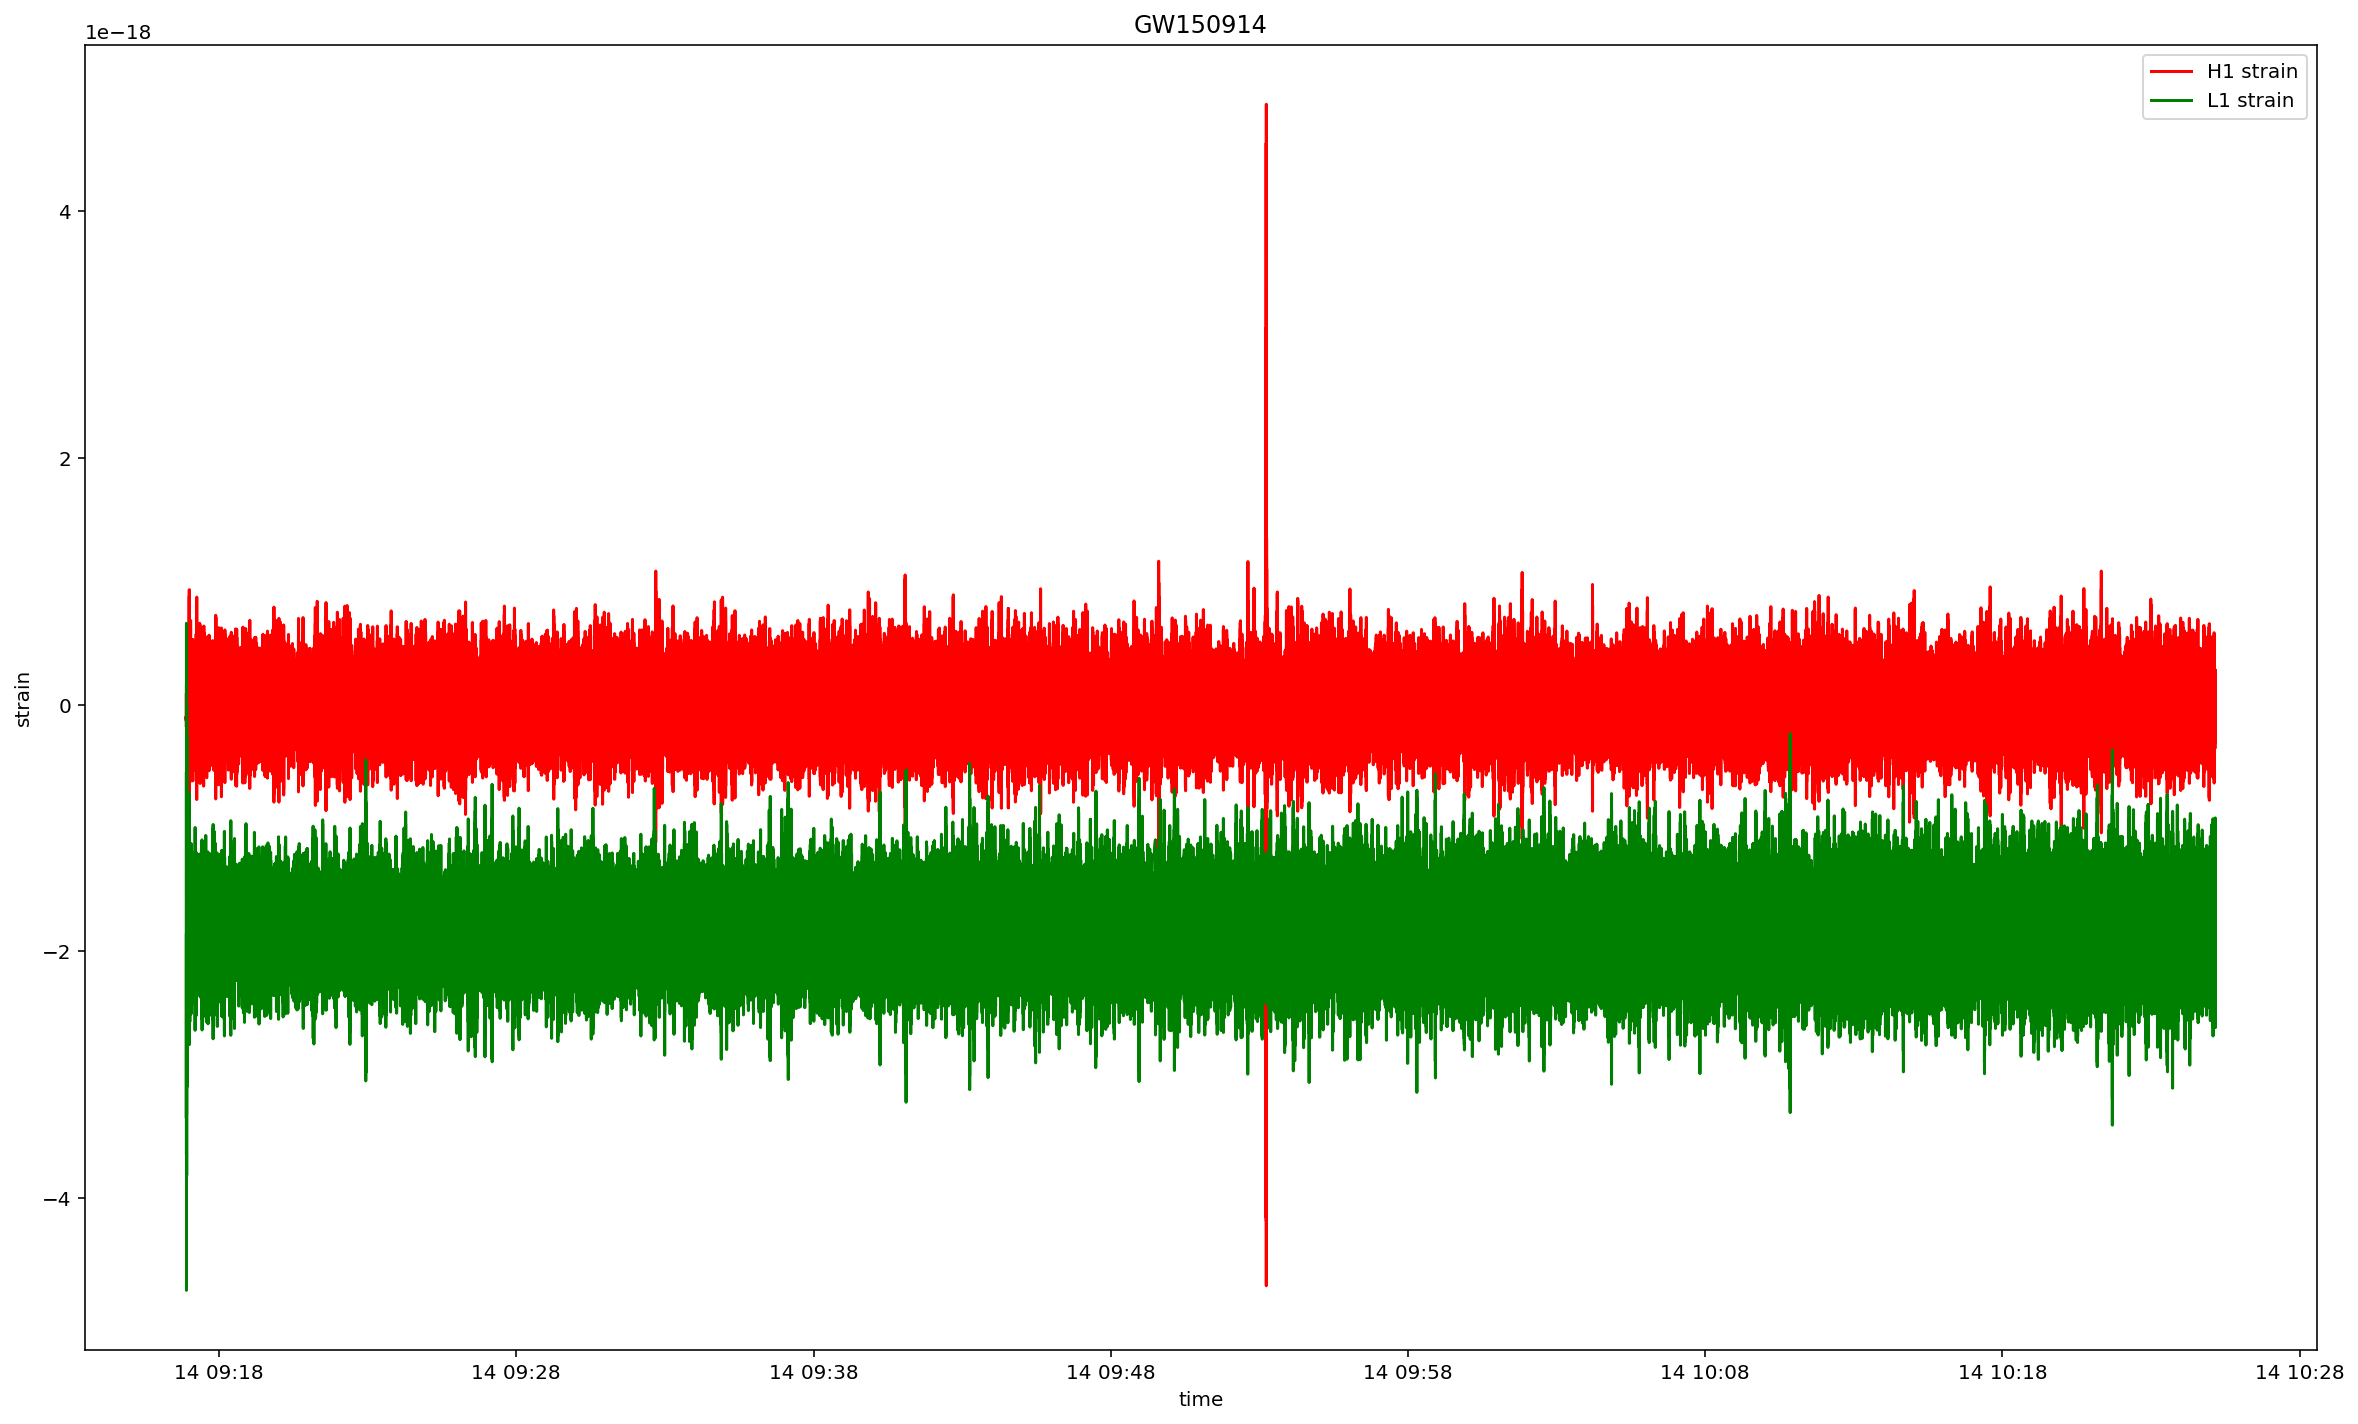

In [4]:
fig, axes = plt.subplots(figsize=(20,12))

axes.plot(S2['time'], S2['strain_H1'],'r',label='H1 strain')
axes.plot(S2['time'], S2['strain_L1'],'g',label='L1 strain')
axes.set_ylabel('strain')
axes.set_xlabel('time')
axes.legend(loc='upper right')
axes.set_title('GW150914')

## Discrete Fourier Transform

We can transform a signal in a time domain into its frequency domain via the fourier transform. Find sinusoids at different frequencies that best fit the signal. Then plot the frequencies against it's amplitude.

Here we have an example using a recorded voice with a low, medium, and high tone in the time domain, which can be seen in the frequency domain.

<img src="images/fourier_transform_voice_example.jpg" width="800" height="600">

<img src="images/amplitude_frequency.jpg" width="800" height="600">

## Discrete Fourier Transform

A signal put into its frequency domain via the Fourier Transform can be used to: reduce noise, compress data, modulate, filter, or encode. 

The detectors have a sampling rate of $fs=4096 Hz$. We cannot capture frequency content above the $\text{Nyquist frequency} = fs/2 = 2048 Hz$. Fine, because GW150914 only has detectable frequency content in the range $20 Hz - 300 Hz$

Difficult to see as event is less than one second long, and frequency is calculated over 32 seconds. 

Will whiten and bandpass to clean in frequency domain. Then transform back into time domain and plot.


#### ASD

Plotting these data in the Fourier domain gives an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density (ASD).

Power Spectral Density (PSD) describes how much the different frequencies contribute to the average power of the signal. ASDs are the square root of the PSDs. 

$$ASD = \sqrt{PSD}$$

#### Whitening

A process with flat power spectrum is referred to as a white process. Taking the fourier transform to get the noise amplitude spectrum and dividing the signal's fourier transform by it will remove background noise. Now in units of sigma away from the mean.

#### Bandpassing

bandpassing is zero for frequencies outside some finite band.

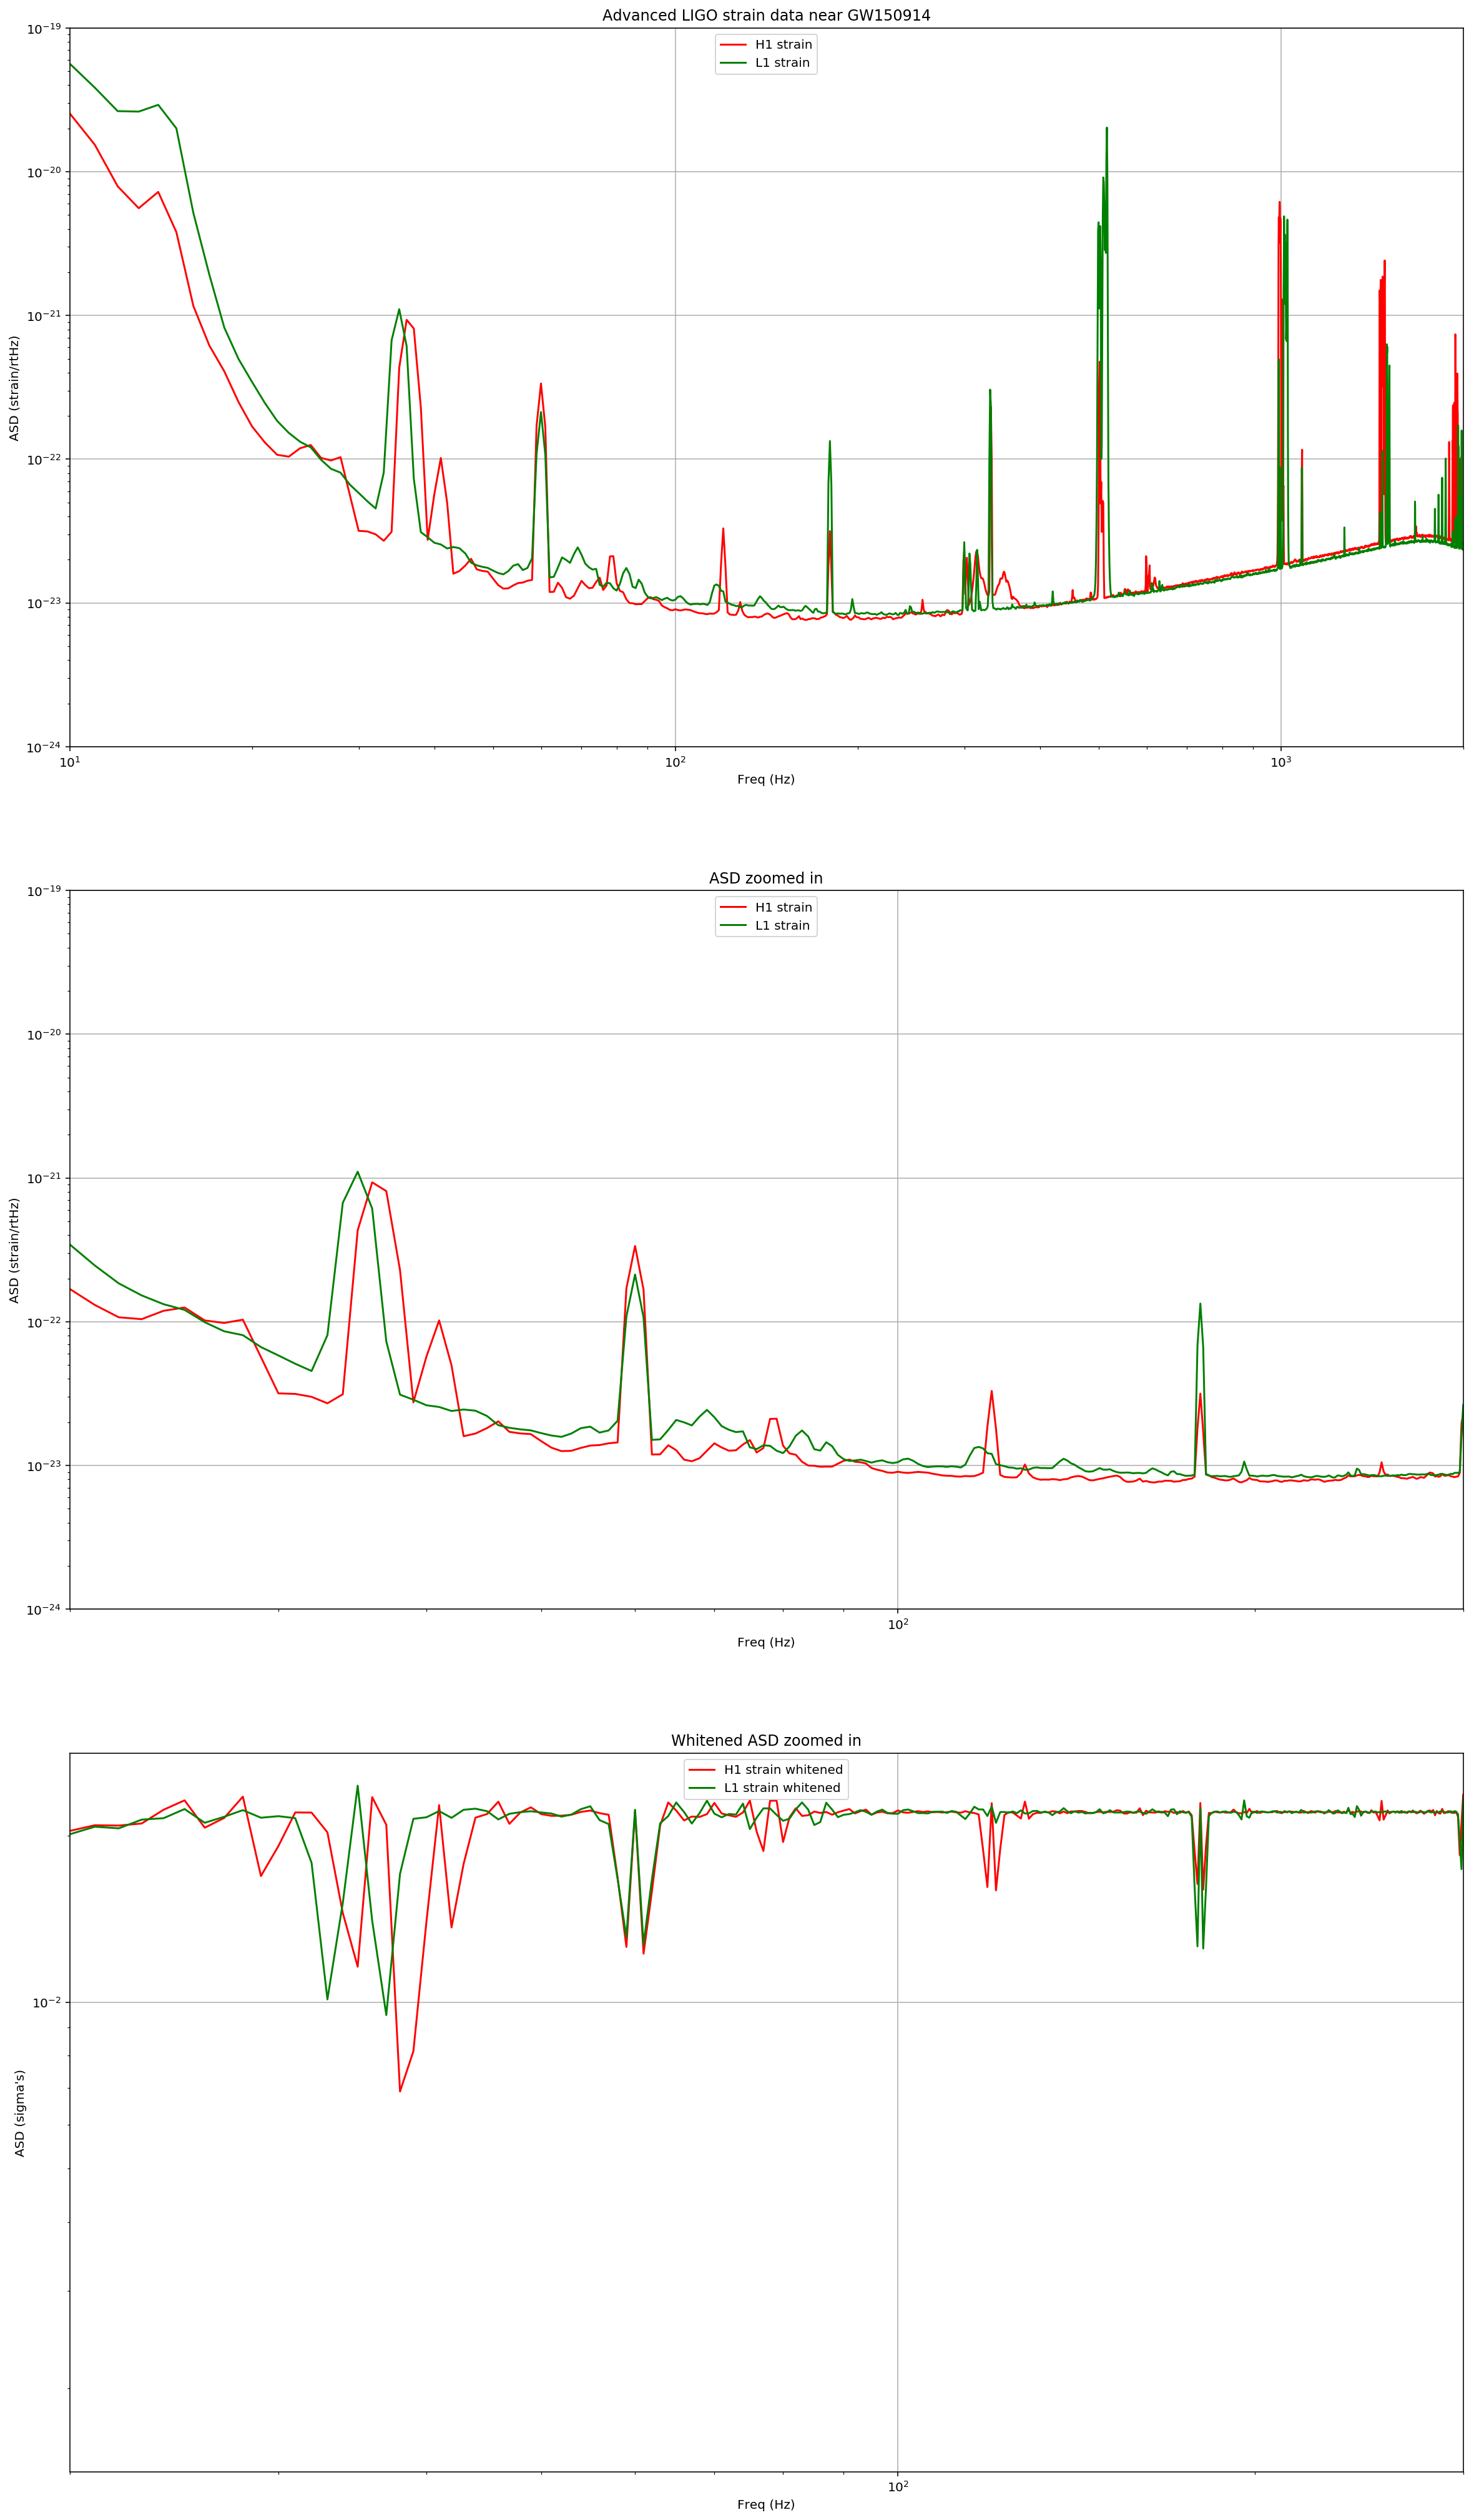

In [6]:
# plot the ASDs:

fig, axes = plt.subplots(figsize=(20,36), nrows=3, ncols=1)

axes[0].loglog(F2['freq'], F2['Pxx_H1'],'r',label='H1 strain')
axes[0].loglog(F2['freq'], F2['Pxx_L1'],'g',label='L1 strain')
axes[0].axis([fmin, fmax, 1e-24, 1e-19])
axes[0].grid('on')
axes[0].set_ylabel('ASD (strain/rtHz)')
axes[0].set_xlabel('Freq (Hz)')
axes[0].legend(loc='upper center')
axes[0].set_title('Advanced LIGO strain data near GW150914')

axes[1].loglog(F2['freq'], F2['Pxx_H1'],'r',label='H1 strain')
axes[1].loglog(F2['freq'], F2['Pxx_L1'],'g',label='L1 strain')
axes[1].axis([20, 300, 1e-24, 1e-19])
axes[1].grid('on')
axes[1].set_ylabel('ASD (strain/rtHz)')
axes[1].set_xlabel('Freq (Hz)')
axes[1].legend(loc='upper center')
axes[1].set_title('ASD zoomed in')

axes[2].loglog(F2['freq'], F2['Pxx_H1_whiten'],'r',label='H1 strain whitened')
axes[2].loglog(F2['freq'], F2['Pxx_L1_whiten'],'g',label='L1 strain whitened')
axes[2].set_xlim(20, 300)
axes[2].grid('on')
axes[2].set_ylabel('ASD (sigma\'s)')
axes[2].set_xlabel('Freq (Hz)')
axes[2].legend(loc='upper center')
axes[2].set_title('Whitened ASD zoomed in')

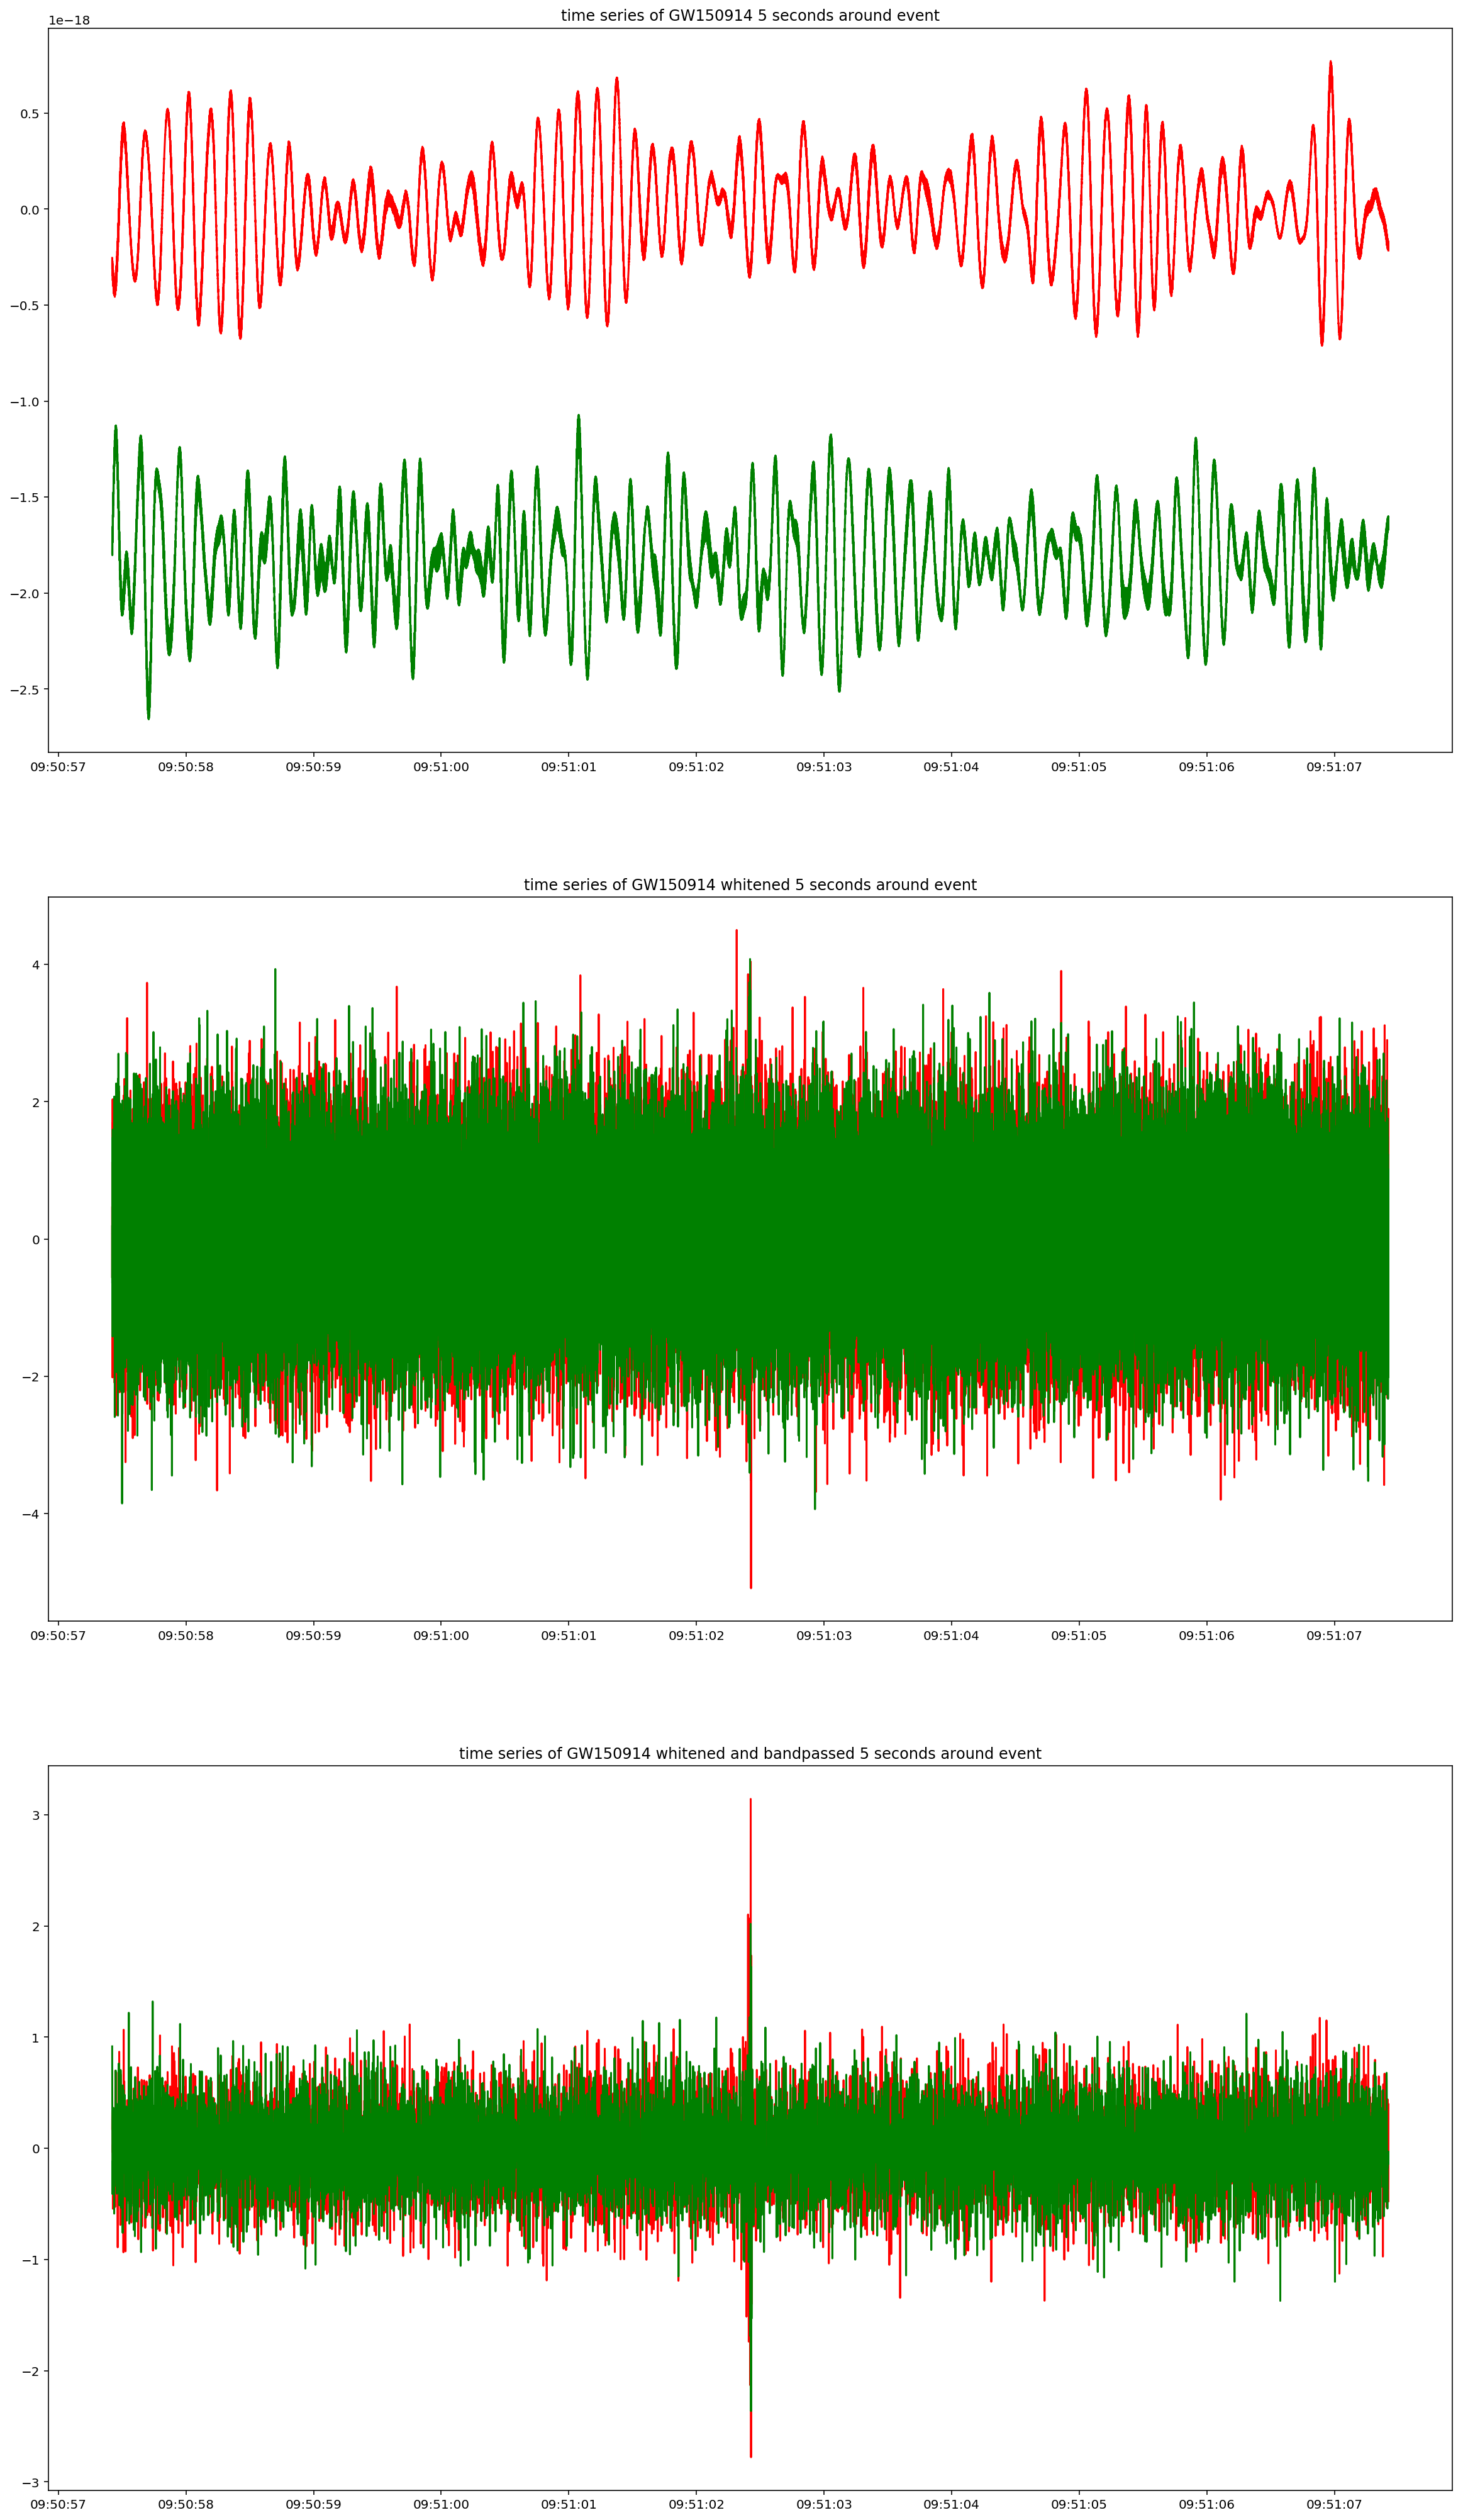

In [7]:
# plot +- 5 seconds around the event:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
tevent = pd.to_datetime(tevent, unit='s', origin=pd.Timestamp('1980-01-06'))
deltat = 5.                     # seconds around the event
deltat = pd.Timedelta(seconds=deltat)
# index into the strain time series for this time interval:
S2_windowed = S2[(S2['time'] > tevent-deltat) & (S2['time'] < tevent+deltat)]

fig, axes = plt.subplots(figsize=(20,36), nrows=3, ncols=1)

axes[0].plot(S2_windowed['time'], S2_windowed['strain_H1'],'r',label='H1 strain')
axes[0].plot(S2_windowed['time'], S2_windowed['strain_L1'],'g',label='L1 strain')
axes[0].set_title('time series of GW150914 5 seconds around event')

axes[1].plot(S2_windowed['time'], S2_windowed['strain_H1_whiten'],'r',label='H1 strain_whiten')
axes[1].plot(S2_windowed['time'], S2_windowed['strain_L1_whiten'],'g',label='L1 strain_whiten')
axes[1].set_title('time series of GW150914 whitened 5 seconds around event')

axes[2].plot(S2_windowed['time'], S2_windowed['strain_H1_whitenbp'],'r',label='H1 strain_whitenbp')
axes[2].plot(S2_windowed['time'], S2_windowed['strain_L1_whitenbp'],'g',label='L1 strain_whitenbp')
axes[2].set_title('time series of GW150914 whitened and bandpassed 5 seconds around event')

Used interpolated psd to whiten. Therefore higher sampling rate when returned to time domain?

## Progress

* Learned how FFT is an application of the DFT to transform a time series
* Learned about whitening and bandpassing

## Future Work

* Get another known dataset with a GW, apply same methods and find the GW
* Build arma of cleaned data?